# CHB-MIT EDA (Day 3)
This notebook loads the processed window dataset and performs sanity checks:
- dataset stats
- leakage-safe split (file-wise)
- plot one seizure vs one non-seizure window
- alignment check for seizure-labeled windows


In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

NPZ_PATH = PROJECT_ROOT / "data" / "processed" / "chb_subset_windows.npz"
print("Notebook cwd:", Path.cwd())
print("Project root:", PROJECT_ROOT)
print("NPZ path:", NPZ_PATH)
print("Exists?", NPZ_PATH.exists())


Notebook cwd: /Users/rick/Desktop/Machine_learning_projects/seizure-prediction-chbmit/notebooks
Project root: /Users/rick/Desktop/Machine_learning_projects/seizure-prediction-chbmit
NPZ path: /Users/rick/Desktop/Machine_learning_projects/seizure-prediction-chbmit/data/processed/chb_subset_windows.npz
Exists? True


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.datasets.eeg_dataset import EEGWindowsDataset, make_stratified_filewise_split_indices

d = np.load(NPZ_PATH, allow_pickle=True)

print('keys:', list(d.keys()))
X = d['X']
y = d['y']
source_files = d['source_files']
patient_ids = d['patient_ids']
fs = float(d['fs'])
window_sec = float(d['window_sec'])
channels = d['channels'].tolist()

print('X:', X.shape, 'y:', y.shape)
print('label counts:', dict(zip(*np.unique(y, return_counts=True))))
print('fs:', fs, 'window_sec:', window_sec)
print('channels:', len(channels))
print('patients list in file:', d['patients'].tolist())


keys: ['X', 'y', 'fs', 'window_sec', 'channels', 'patients', 'source_files', 'patient_ids']
X: (29197, 23, 1280) y: (29197,)
label counts: {np.int64(0): np.int64(29104), np.int64(1): np.int64(93)}
fs: 256.0 window_sec: 5.0
channels: 23
patients list in file: ['chb01']


In [3]:
# Train/Val/Test split (file-wise, with seizure guaranteed in val/test when possible)
train_idx, val_idx, test_idx = make_stratified_filewise_split_indices(NPZ_PATH, seed=123)
train_ds = EEGWindowsDataset(NPZ_PATH, indices=train_idx)
val_ds = EEGWindowsDataset(NPZ_PATH, indices=val_idx)
test_ds = EEGWindowsDataset(NPZ_PATH, indices=test_idx)
print('Train:', train_ds.stats())
print('Val:', val_ds.stats())
print('Test:', test_ds.stats())


Train: {'num_windows': 23572, 'num_channels': 23, 'window_len': 1280, 'label_counts': {0: 23509, 1: 63}, 'fs': 256.0, 'window_sec': 5.0, 'patients': ['chb01']}
Val: {'num_windows': 2025, 'num_channels': 23, 'window_len': 1280, 'label_counts': {0: 2004, 1: 21}, 'fs': 256.0, 'window_sec': 5.0, 'patients': ['chb01']}
Test: {'num_windows': 3600, 'num_channels': 23, 'window_len': 1280, 'label_counts': {0: 3591, 1: 9}, 'fs': 256.0, 'window_sec': 5.0, 'patients': ['chb01']}


Example non-seizure idx: 0
Example seizure idx: 2039
Seizure window source file: chb01_03.edf


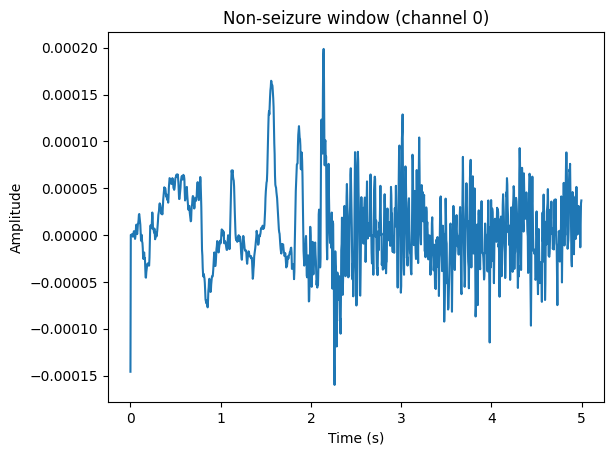

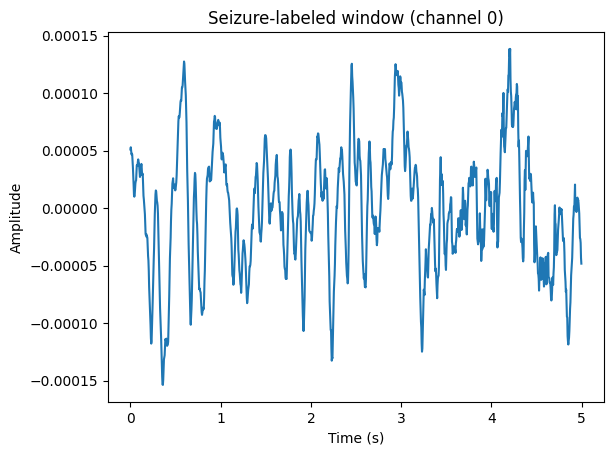

In [4]:
# Pick one non-seizure and one seizure window (from full y)
idx_non = int(np.where(y == 0)[0][0])
idx_seiz = int(np.where(y == 1)[0][0])
print('Example non-seizure idx:', idx_non)
print('Example seizure idx:', idx_seiz)
print('Seizure window source file:', source_files[idx_seiz])

x0 = X[idx_non]
x1 = X[idx_seiz]

# Plot a single channel for readability (channel 0)
t = np.arange(x0.shape[1]) / fs

plt.figure()
plt.plot(t, x0[0])
plt.title('Non-seizure window (channel 0)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.figure()
plt.plot(t, x1[0])
plt.title('Seizure-labeled window (channel 0)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


In [5]:
# Alignment check: for the chosen seizure window, compute its approximate time range inside its EDF
# We can only do this reliably if we know the window's position within that EDF.
# Here we'll estimate by counting how many windows came earlier in the same EDF.

seiz_file = source_files[idx_seiz]
mask_same_file = (source_files == seiz_file)
idxs_in_file = np.where(mask_same_file)[0]

# position of idx_seiz among windows of that file
pos = int(np.where(idxs_in_file == idx_seiz)[0][0])
win_start_sec = pos * window_sec
win_end_sec = win_start_sec + window_sec

print('Seizure window belongs to:', seiz_file)
print('Window position within that file:', pos)
print('Estimated window time range (sec):', (win_start_sec, win_end_sec))

print('\nNext: compare this time range against seizure intervals from the summary file for that EDF (manual check).')


Seizure window belongs to: chb01_03.edf
Window position within that file: 599
Estimated window time range (sec): (2995.0, 3000.0)

Next: compare this time range against seizure intervals from the summary file for that EDF (manual check).


In [6]:
# Compute the window's position within its EDF file
seiz_file = source_files[idx_seiz]
mask = (source_files == seiz_file)
idxs_in_file = np.where(mask)[0]

pos_in_file = int(np.where(idxs_in_file == idx_seiz)[0][0])

win_start = pos_in_file * window_sec
win_end = win_start + window_sec

print("Seizure EDF file:", seiz_file)
print("Window position within file:", pos_in_file)
print("Window time range (sec):", (win_start, win_end))

# CHB-MIT summary annotation for chb01_03.edf (from chb01-summary.txt):
sz_start, sz_end = 2996.0, 3036.0

overlaps = (win_start < sz_end) and (win_end > sz_start)
print("Annotated seizure interval (sec):", (sz_start, sz_end))
print("Overlaps annotated seizure?", overlaps)


Seizure EDF file: chb01_03.edf
Window position within file: 599
Window time range (sec): (2995.0, 3000.0)
Annotated seizure interval (sec): (2996.0, 3036.0)
Overlaps annotated seizure? True
